In [1]:
# Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
# Pull SPY data; 10 years ago until today.
# We are pulling data from SPY since it's the ticker for the S&P 500.
# This is the best way to track the total market's trend.
df = yf.download("SPY", start="2014-01-01", end="2024-02-26")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,152.669144,119636900
2014-01-03,183.229996,183.600006,182.630005,182.889999,152.644135,81390600
2014-01-06,183.490005,183.559998,182.080002,182.360001,152.201767,108028200
2014-01-07,183.089996,183.789993,182.949997,183.479996,153.136566,86144200
2014-01-08,183.449997,183.830002,182.889999,183.520004,153.169876,96582300
...,...,...,...,...,...,...
2024-02-16,501.700012,502.869995,498.750000,499.510010,499.510010,75461200
2024-02-20,497.720001,498.410004,494.450012,496.760010,496.760010,71736700
2024-02-21,495.420013,497.369995,493.559998,497.209991,497.209991,59603800


Text(0, 0.5, 'Close Price USD')

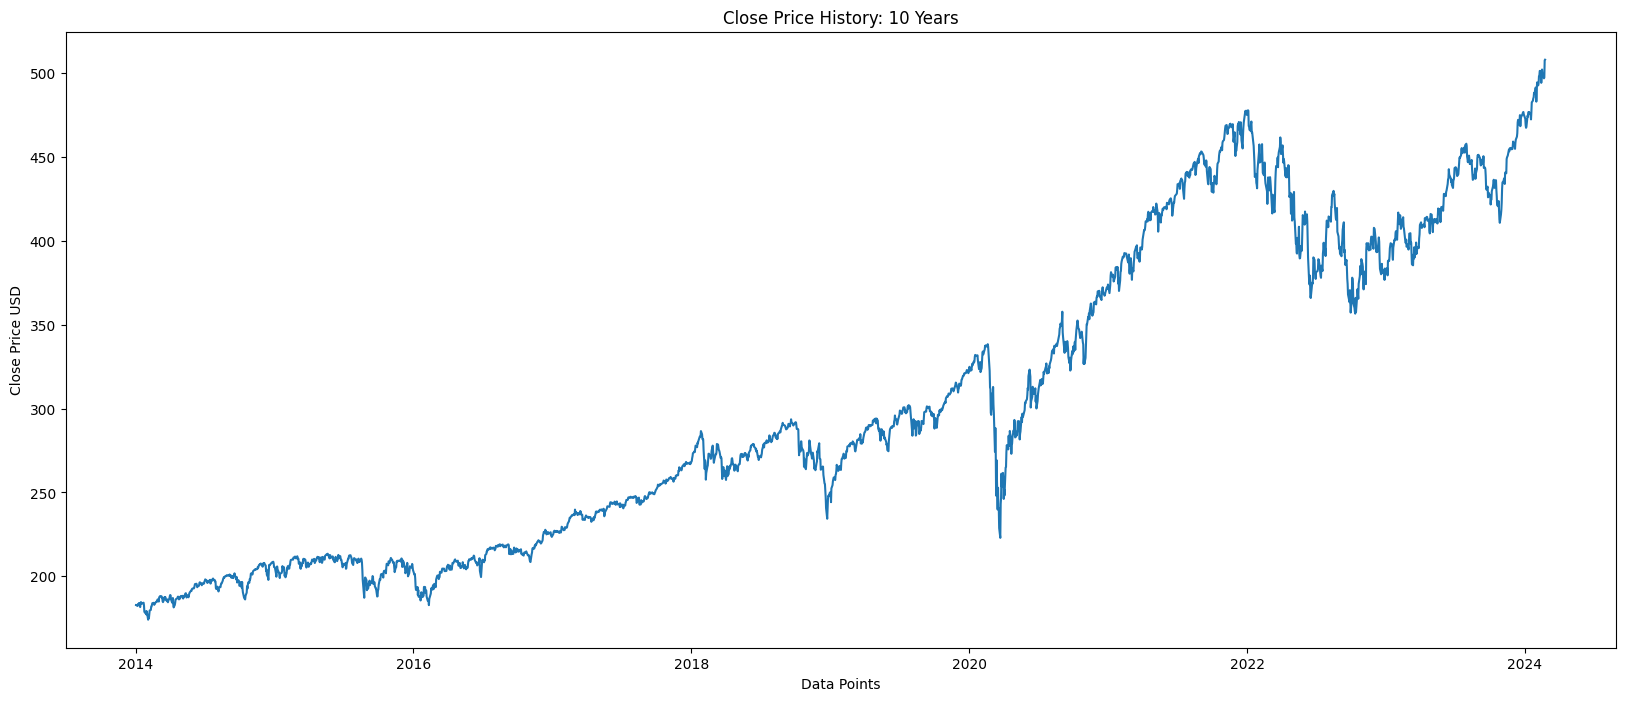

In [3]:
# Plot trend.
plt.figure(figsize=(20,8))
plt.title('Close Price History: 10 Years')
plt.plot(df['Close'])
plt.xlabel('Data Points', fontsize=10)
plt.ylabel('Close Price USD')

In [4]:
# Create new dataframe with only the 'Close' column.
# This will give us only the close price data.
data = df.filter(['Close'])

# Convert dataframe to a numpy array.
dataset = data.values

# Retrieve the number of rows that we will TRAIN our model on.
# We will be training our model on 80% of the dataset.
training_data_len = math.ceil((len(dataset) * 0.8))
training_data_len

2043

In [5]:
# Scaling the data.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02622273],
       [0.02613282],
       [0.02454448],
       ...,
       [0.96811312],
       [0.99895107],
       [1.        ]])

In [6]:
# Create training dataset.
train_data = scaled_data[0:training_data_len , :]
# Split data into x_train and y_train.
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i - 60:i, 0])
  y_train.append(train_data[i, 0])


In [7]:
# Convert to numpy arrays.
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
# Reshape the data from 2-d space to 3-d space.
# The LSTM model requires a 3-d shape.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
# Building the LSTM model.
model = Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# MSE loss function and adam optimizer.
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Training the model on our data (and hope I don't overfit).
model.fit(x_train, y_train, batch_size=1, epochs=1)

1983/1983 [==============================] - 80s 40ms/step - loss: 4.5101e-04


In [18]:
# Create the testing data set.
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i - 60:i, 0])

# Convert the data to a numpy array.
x_test = np.array(x_test)

# Reshape the data.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Get the model's predicted price values.
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 3s 37ms/step


In [24]:
# Root mean squared error.
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.267272336719419

<ipython-input-25-7071db6ce880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


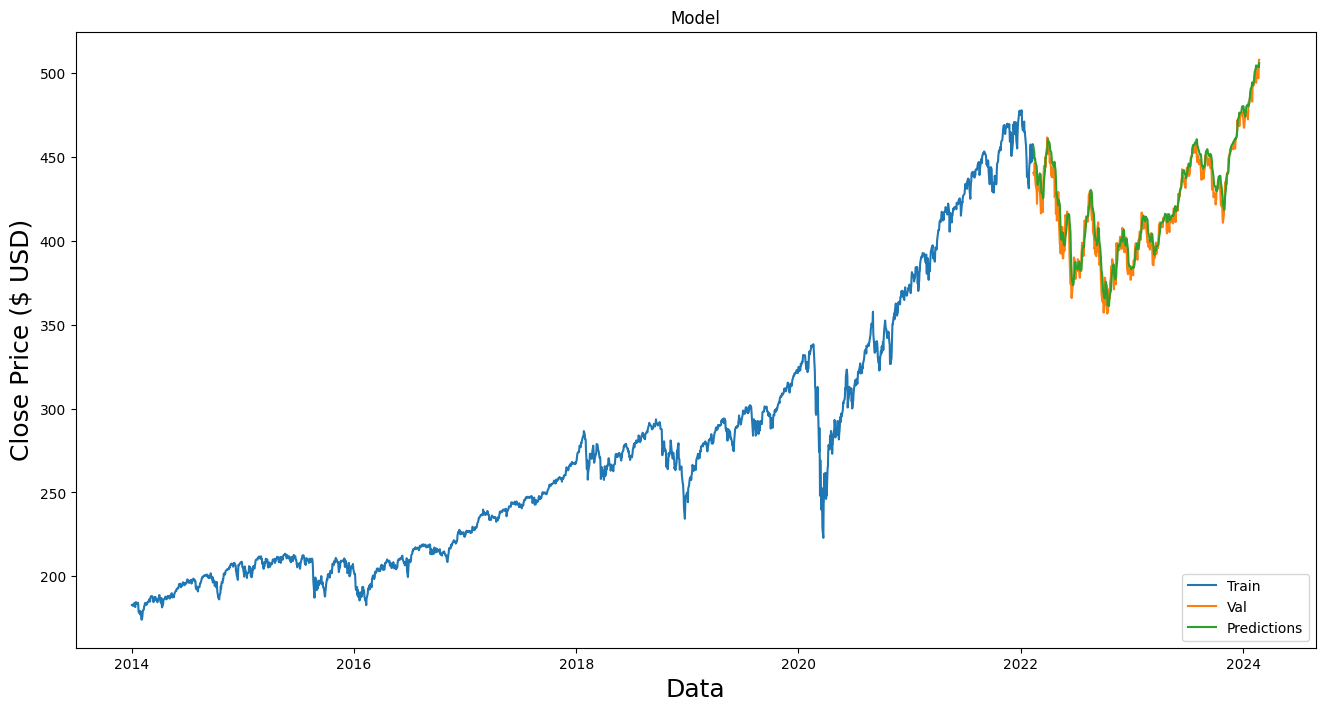

In [25]:
# Plot our results.
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the dat
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price ($ USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [26]:
valid

,Close,Predictions
Date,,
2022-02-11,440.459991,456.239288
2022-02-14,439.019989,452.974304
2022-02-15,446.100006,449.262115
2022-02-16,446.600006,448.401855
2022-02-17,437.059998,448.825714
...,...,...
2024-02-16,499.510010,504.063263
2024-02-20,496.760010,504.469757
2024-02-21,497.209991,503.860657


In [46]:
market_quote = yf.download("SPY", start="2014-01-01", end="2024-03-03")
new_df = market_quote.filter(['Close'])

last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 46ms/step
[[514.0547]]


In [55]:
market_quote_real = yf.download("SPY", start="2024-03-04", end="2024-03-05")
print(market_quote_real.filter(['Close']))

[*********************100%%**********************]  1 of 1 completed

                 Close
Date                  
2024-03-04  512.299988
